# 使用CNN对CIFAR10图像进行分类

在这个教程中，我们使用CIFAR10数据集，它有如下10个类别
：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。CIFAR-10的图像都是3x32x32大小的，即，3颜色通道，32x32像素。

https://gitee.com/tekin/pytorch-handbook/blob/master/chapter1/4_cifar10_tutorial.ipynb

训练一个图像分类器


- 使用torchvision加载和归一化CIFAR10训练集和测试集
- 定义一个卷积神经网络
- 定义损失函数
- 在训练集上训练网络
- 在测试集上测试网络



## 使用torchvision加载和归一化CIFAR10训练集和测试集

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/Users/datalab/bigdata', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='/Users/datalab/bigdata', train=False,
                                       download=True, transform=transform)


Extracting /Users/datalab/bigdata/cifar-10-python.tar.gz to /Users/datalab/bigdata
Files already downloaded and verified


In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

truck   dog horse   cat


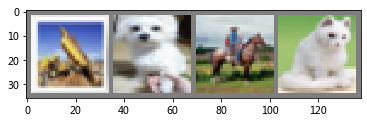

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图像的函数


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 获取随机数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 定义一个卷积神经网络

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 定义损失函数

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 在训练集上训练网络

In [11]:
for epoch in range(2):  # 多批次循环

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # 获取输入
        inputs, labels = data

        # 梯度置0
        optimizer.zero_grad()

        # 正向传播，反向传播，优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印状态信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000批次打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.285
[1,  4000] loss: 1.939
[1,  6000] loss: 1.714
[1,  8000] loss: 1.600
[1, 10000] loss: 1.510
[1, 12000] loss: 1.477
[2,  2000] loss: 1.399
[2,  4000] loss: 1.356
[2,  6000] loss: 1.337
[2,  8000] loss: 1.312
[2, 10000] loss: 1.305
[2, 12000] loss: 1.276
Finished Training


## 在训练集上训练网络

GroundTruth:    cat  ship  ship plane


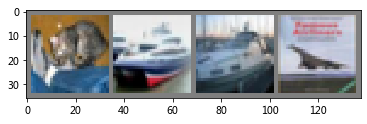

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
outputs = net(images)


In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship  ship


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 59 %
Accuracy of  bird : 23 %
Accuracy of   cat : 15 %
Accuracy of  deer : 33 %
Accuracy of   dog : 64 %
Accuracy of  frog : 83 %
Accuracy of horse : 64 %
Accuracy of  ship : 66 %
Accuracy of truck : 70 %


如何进一步改进模型？